In [25]:

# Imports for making plots inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# Imports for the calculation
import scipy as sp
from numpy import isscalar
from scipy.linalg import inv, cholesky, solve, lu_factor, lu_solve
from scipy import stats


In [30]:
# Function to sample a covariance matrix
def gaussian_draw(mean, S, draws=1, draw=stats.norm.rvs):
    """
    Return a random sample of the given multivariate gaussian 
    density function defined by the mean and covariance matrix.

    IN
    ==
    mean   - Array with shape (N,)   
    S      - The covariance matrix OR its diagonal OR the variance for i.i.d. Gaussian
    draws  - numer of smaples to make (returned along first dimention)
    draw   - The standard normal random number generator
    """
    # Check size of random vector 
    N = mean.size
    
    # check for diagonality of covariance matrix
    if isscalar(S):
        Croot = sp.eye(N) * sp.sqrt(S)
        
    elif len(S.shape) == 1:
        assert S.size == N
        Croot = sp.diag(sp.sqrt(S))
        
    elif len(S.shape) == 2:
        assert S.size == N**2
        Croot = cholesky(S).transpose()

    # Sample from standard normal and transpose
    xstand = draw(size=N*draws).reshape(N, draws)
    
    # Transform to a variable with the right mean and covariance.
    xout = sp.dot(Croot, xstand).T + mean

    return sp.squeeze(xout)


# Function for computing the moments of a given set of samples 
def chi2_moments(x, S, mean=None):
    """
    Compute the normalized 
    S ~ (N,N)
    x ~ (Nsamples, N)
    """
    
    # Check size of random vector 
    Nsamples, N = x.shape
    
    # Define a covariance matrix from S
    if isscalar(S):
        Sinv = sp.eye(N) / S
    elif len(S.shape) == 1:
        assert S.size == N
        Sinv = sp.diag(1.0 / S)
            
    elif len(S.shape) == 2:
        assert S.size == N**2
        Sinv = inv(S)         
    else:
        raise ValueError('S~{} and x~{} are not compatable.'.format(S.shape, x.shape))

    # Define the mean if not given
    if mean is None: 
        DOF = N-1
        mean = x.mean(0)
    else:
        DOF = N

    # We need S inverse to compute chi-squared . . . 
    # For some reason I thought it would be clever to use LU factorization 
    z = x - mean
    zz = z.reshape(Nsamples, N, -1) * z.reshape(Nsamples, -1, N)
    chi2 = sp.tensordot(zz, Sinv, axes=[(1,2), (0,1)]) 
    
    # The draw for probability S can be tested by 
    chi2_mean = chi2.mean()
    chi2_var = ((chi2-chi2_mean)**2).sum()/(Nsamples-1.0)
    std = sp.sqrt(chi2_var)
    chi2_skew = ((chi2-chi2_mean)**3).mean() / std**3
    chi2_kert = ((chi2-chi2_mean)**4).mean() / std**4
    return DOF, chi2_mean, chi2_var, chi2_skew, chi2_kert


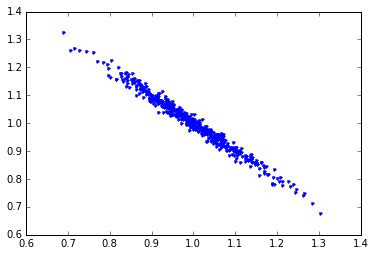

In [31]:
# make a simple plot of a 2D case
M = 500

# The mean 
xmean = sp.array([1.0, 
                  1.0])

# The covariance matrix
S = (.1)**2 * sp.array([[1.0, -0.99], 
                        [-0.99, 1.0]])

# Draw a bunch of samples
xdraws = gaussian_draw(xmean, S, M)

# Plot them
fig = plt.figure(0)
fig.clf()
plots = plt.plot(*xdraws.T, linewidth=0, marker='.')


In [33]:
# Example: three test cases to make sure that the chi2 values look OK

# Choose the size of the examples to run
N = 100
M = 50000

# First example (S0 is a full covariance matrix)
x0 = sp.ones(N)
S0 = sp.ones((N,N)) + sp.eye(N)
xdraws0 = gaussian_draw(x0, S0, draws=M)

msg = """
Chi2 results:
=============
N = {0}, \tM = {M}
chi2_mean = {1}
chi2_var = {2}
chi2_skew = {3}
chi2_kert = {4}

"""
print(msg.format(*chi2_moments(xdraws0, S0, mean=x0), M=M))

 
# Second example (S1 is given as the diagonal elements)
x1 = sp.ones(N)
S1 = sp.arange(N) + 1.0
xdraws1 = gaussian_draw(x1, S1, draws=M)
print(msg.format(*chi2_moments(xdraws1, S1, mean=x1), M=M))

# Third example (S2 is given as the variance)
x2 = sp.ones(N)
S2 = (100.0)**2 # variance is sig**2
xdraws2 = gaussian_draw(x2, S2, draws=M)
print(msg.format(*chi2_moments(xdraws2, S2, mean=x2), M=M))



Chi2 results:
N = 100, 	M = 50000
chi2_mean = 99.9861761857
chi2_var = 201.423168326
chi2_skew = 0.287296732698
chi2_kert = 3.136647308



Chi2 results:
N = 100, 	M = 50000
chi2_mean = 99.9689155454
chi2_var = 197.910990255
chi2_skew = 0.280885437341
chi2_kert = 3.05539817348



Chi2 results:
N = 100, 	M = 50000
chi2_mean = 99.9385225008
chi2_var = 201.581928044
chi2_skew = 0.288294972394
chi2_kert = 3.13279346696


